# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'2.3.1'

# Load Data

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print("Size of:")
print(" - Training-set:\t\t{}".format(len(x_train)))
print(" - Test-set:\t\t\t{}".format(len(x_test)))

Size of:
 - Training-set:		60000
 - Test-set:			10000


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
import sys
print("The Memory size of x_train = {} MBs".format(int(sys.getsizeof(x_train))/1000000))

The Memory size of x_train = 47.040128 MBs


# Helper function for plotting the images

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Data Dimensions

In [9]:
# We know that MNIST images are 28 pixels by 28 pixels
img_size = 28

# Images are stored in one-dimensional arrays of this length - number of numbers in the matrix of size 28 x 28
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image: 1 channel for gray-scale
num_channels = 1

# Number of classes, one class for each of 10 digits
num_classes = 10

# Visualise Data

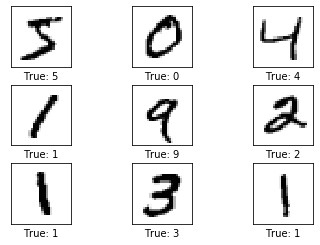

In [10]:
# Get the first images from the train set.
images = x_train[0:9]

# Get the true classes for those images.
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Hyperparameters of the Neural Network

In [11]:
# Convolutional layer 1
filter1_size = 5  #Convolution filters are 5 x 5 pixels
num_filters1 = 16 #There are 16 of these filters

# Convolutional layer 2
filter2_size = 5 #Convolution filters are 5 x 5 pixels
num_filters2 = 32 #There are 32 of these filters

# Pooling
window_size = 2 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=128     # Number of nodes in the fully-connected layer

# Convolution stride
conv_stride=1

## Helper function for Creating Weights

In [12]:
def weights(shape):
    weights = tf.Variable(tf.random.normal(shape=shape, stddev=0.05))
    return weights

## ConvNet 1

In [105]:
def ConvNet1(image):
    # Conv1 layer
    shape_1 = [filter1_size, filter1_size, num_channels, num_filters1]
    shape_bias1 = [num_channels, img_size, img_size, num_filters1]
    conv1_weights = weights(shape_1)
    bias_1 = tf.Variable(tf.ones(shape=shape_bias1))
    conv1 = tf.nn.conv2d(input=image, filters=conv1_weights, strides=conv_stride, padding='SAME')
    conv1+=bias_1
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(input=conv1, ksize=window_size, strides=window_stride, padding='SAME')
    return conv1

## ConvNet2

In [106]:
def ConvNet2(conv1):
    # Conv2 Layer
    shape_2 = [filter2_size, filter2_size, num_filters1, num_filters2]
    shape_bias2 = [num_channels, conv1.shape[1], conv1.shape[1], num_filters2]
    conv2_weights = weights(shape_2)
    bias_2 = tf.Variable(tf.ones(shape=shape_bias2))
    conv2 = tf.nn.conv2d(input=conv1, filters=conv2_weights, strides=conv_stride, padding='SAME')
    conv2+=bias_2
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(input=conv2, ksize=window_size, strides=window_stride, padding='SAME')
    return conv2

## Flatten Layer

In [107]:
def flatten_layer(conv2):
    layer_shape = conv2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(conv2, [-1, num_features])
    return flat_layer, num_features

## Fully Connected Layer

In [108]:
# Fully connected layer
num_features=7*7*32 # 7 x 7 filtered images of 32 pieces for each image
fc_shape = [num_features, fc_size]
fc_weights = tf.Variable(tf.random.normal(shape=fc_shape))
bias_fc = tf.Variable(tf.ones([fc_size]))
# Output layer
shape_out = [fc_size, num_classes]
w_out = tf.Variable(tf.random.normal(shape=shape_out))
b_out = tf.Variable(tf.ones([num_classes]))

In [109]:
def make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out):
    #Fully connected layer
    fc_product = tf.matmul(flat_layer, fc_weights)
    fully_connected = tf.keras.activations.relu(fc_product+bias_fc)
    # Output layer
    output = tf.matmul(fully_connected, w_out)
    prediction = tf.keras.activations.softmax(output + b_out)
    return prediction

In [110]:
def model(image):
    conv1 = ConvNet1(image)
    conv2 = ConvNet2(conv1)
    flat_layer, num_features = flatten_layer(conv2)
    predictions = make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out)
    return predictions

## Compile and Train the model

In [111]:
optimizer = tf.keras.optimizers.Adam()

In [112]:
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [113]:
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [114]:
# Prepare the training data set

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Prepare the input data 
x_training = tf.constant(x_train, tf.float32)
y_training = tf.constant(y_train, tf.int64)
# Prepare the input data
x_testing = tf.constant(x_test, tf.float32)
y_testing = tf.constant(y_test, tf.int64)

# Reshape as required for ConvNet
new_shape = [-1, img_size, img_size, num_channels]
x_training = tf.reshape(tensor = x_training, shape = new_shape)
#y_training = tf.one_hot(y_training,depth=10) # One-hot encoding of the target variable as required by the model
x_testing = tf.reshape(tensor = x_testing, shape = new_shape)
#y_testing = tf.one_hot(y_testing,depth=10) # One-hot encoding of the target variable as required by the model

In [115]:
x_training.shape, x_testing.shape, y_training.shape, y_testing.shape

(TensorShape([60000, 28, 28, 1]),
 TensorShape([10000, 28, 28, 1]),
 TensorShape([60000]),
 TensorShape([10000]))

In [116]:
# Package the data into batches
batch_size=32
train_ds = tf.data.Dataset.from_tensor_slices((x_training, y_training)).shuffle(1024).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_testing, y_testing)).batch(batch_size)

# Prepare the validation dataset.
# Reserve 10,000 samples for validation.
x_val = x_training[-10000:]
y_val = y_training[-10000:]
x_train = x_training[:-10000]
y_train = y_training[:-10000]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [123]:
for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
    print("step: {}, x_batch_train size: {}, y_batch_train size: {}".format(step, x_batch_train.shape, y_batch_train.shape))
    break

step: 0, x_batch_train size: (32, 28, 28, 1), y_batch_train size: (32,)


In [121]:
import time

start = time.time()
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, [fc_weights, bias_fc, w_out, b_out])

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, [fc_weights, bias_fc, w_out, b_out]))
        
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 1874 batches.
        if step%1874 == 0 and step!=0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 32))
            
         # Display metrics at the end of every 1874 batch
        if step%1874==0 and step!=0:
            train_acc = train_acc_metric.result()
            print("Training acc: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        #for x_batch_val, y_batch_val in val_dataset:
        #    val_logits = model(x_batch_val)
            # Update val metrics
        #    val_acc_metric.update_state(y_batch_val, val_logits)
        #val_acc = val_acc_metric.result()
        #val_acc_metric.reset_states()
        #print("Validation acc: %.4f" % (float(val_acc),))
print("Time taken: %.2fs" % (time.time() - start))


Start of epoch 0
Training loss (for one batch) at step 1874: 2.3362
Seen so far: 60000 samples
Training acc over epoch: 0.1250

Start of epoch 1
Training loss (for one batch) at step 1874: 2.3362
Seen so far: 60000 samples
Training acc over epoch: 0.1250
Time taken: 84.08s
